In [25]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from checkpointer import Checkpointer


In [26]:
from dataset import DatasetPath, dataloader
from models.mpnn import AlignedMPNN
import jax 
import jax.numpy as jnp
import haiku as hk
from pathlib import Path
MODEL_DIR = Path(Path.cwd(), "trained_models")
MODEL_DIR.mkdir(exist_ok=True, parents=True)

In [27]:
sns.set(style='whitegrid')
sns.set_context('notebook')

In [28]:
train_dataloader = dataloader(DatasetPath.TRAIN_PATH)
(
    (
        input_node_features,
        input_edge_features,
        input_graph_features,
        input_adjacency_matrix,
        input_hidden_node_features,
    ),
    transformer_node_features_all_layers,
    transformer_edge_embedding,
) = next(train_dataloader)

In [29]:
for batch in dataloader(DatasetPath.TRAIN_PATH):
    inputs, targets = batch[:-1], batch[-1]
    batch = (
        *inputs,
        targets,
    )
    break

In [30]:
def model_fn(node_fts, edge_fts, graph_fts, adj_mat, hidden):
    model = AlignedMPNN(
        nb_layers=3,
        out_size=192,
        mid_size=192,
        activation=None,
        reduction=jnp.max,
        num_layers=3,
    )
    return model(node_fts, edge_fts, graph_fts, adj_mat, hidden)


model = hk.without_apply_rng(hk.transform(model_fn))
parameters = model.init(
    jax.random.PRNGKey(42),
    node_fts=input_node_features,
    edge_fts=input_edge_features,
    graph_fts=input_graph_features,
    adj_mat=input_adjacency_matrix,
    hidden=input_hidden_node_features,
)
ckpt = Checkpointer(f"{MODEL_DIR}/untrained_mpnn.pkl")#aligned_mpnn_all_layers.pkl")
parameters = ckpt.load()

In [31]:
jax.numpy.asarray(transformer_edge_embedding).ravel()


Array([-0.4405831 ,  0.4935946 , -1.2416583 , ...,  0.02483042,
       -0.02086635, -0.00683404], dtype=float32)

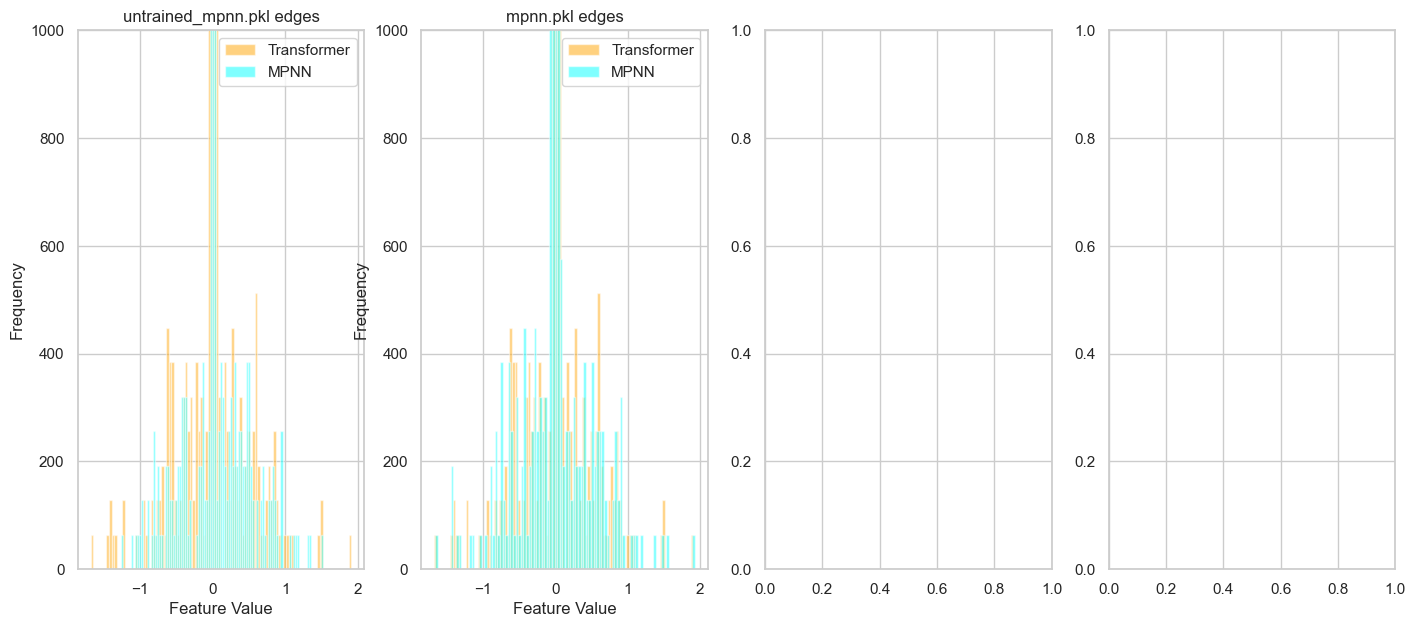

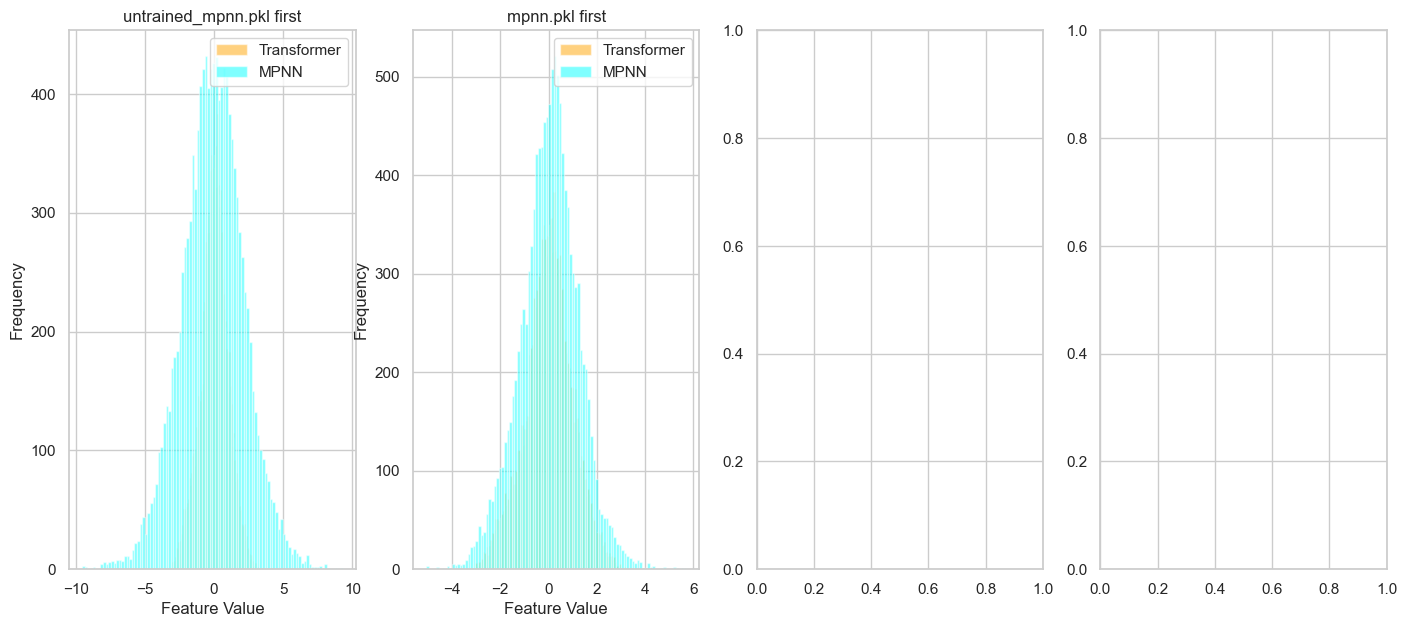

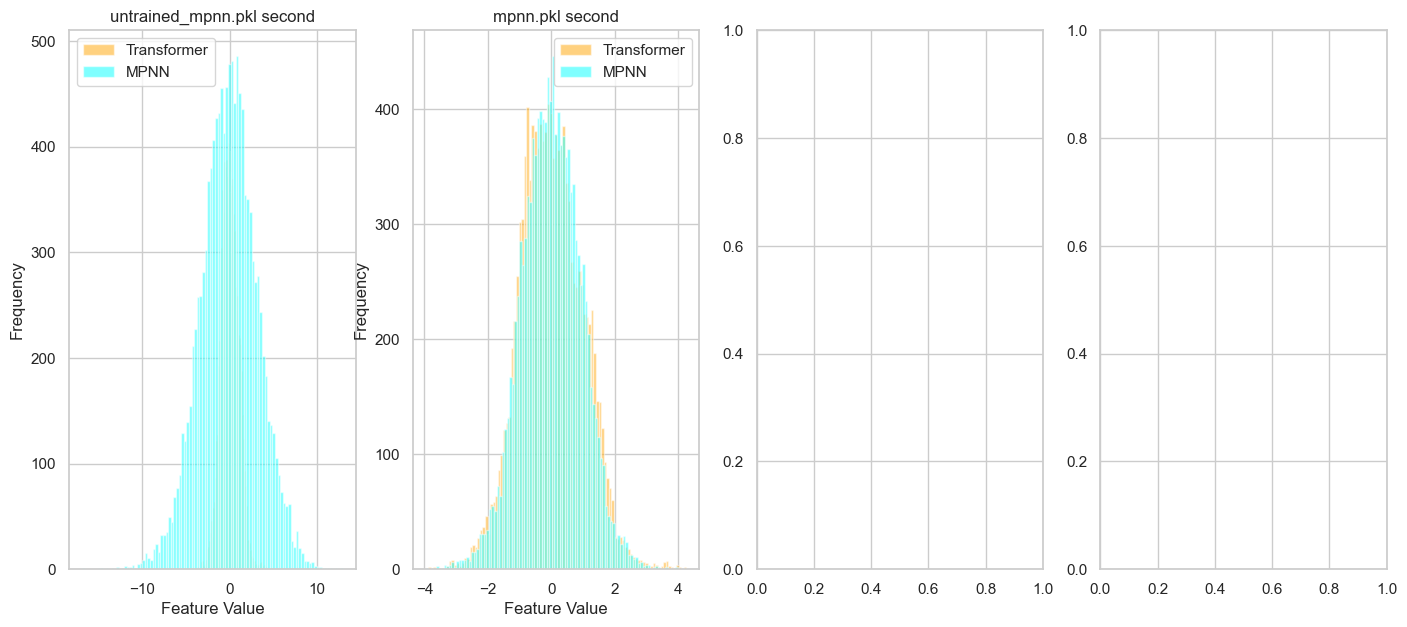

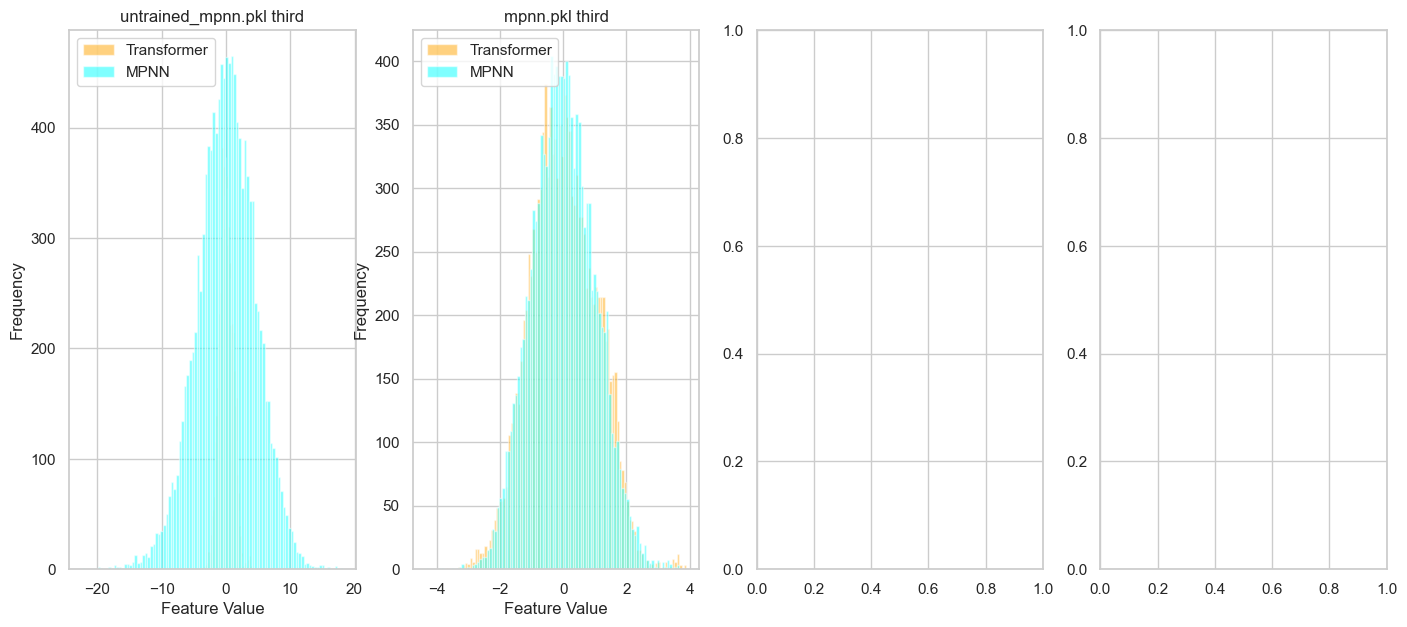

In [37]:
fig, ax_edge = plt.subplots(1, 4, figsize=(17,7))
fig, ax_first = plt.subplots(1, 4, figsize=(17,7))
fig, ax_second = plt.subplots(1, 4, figsize=(17,7))
fig, ax_third = plt.subplots(1, 4, figsize=(17,7))
for i, path in enumerate(["untrained_mpnn.pkl", "mpnn_vn_all_layers.pkl"]):#"aligned_mpnn_all_layers.pkl", "aligned_mpnn_last_layer.pkl", "aligned_mpnn_one_edge.pkl"]):
    # LOAD MODEL 
    model = hk.without_apply_rng(hk.transform(model_fn))
    parameters = model.init(
        jax.random.PRNGKey(42),
        node_fts=input_node_features,
        edge_fts=input_edge_features,
        graph_fts=input_graph_features,
        adj_mat=input_adjacency_matrix,
        hidden=input_hidden_node_features,
    )
    ckpt = Checkpointer(f"{MODEL_DIR}/{path}")#aligned_mpnn_all_layers.pkl")
    parameters = ckpt.load()

    # GET TRANSFORMER LAYER and EDGE EMBEDDINGS
    (
    (
        input_node_fts,
        input_edge_fts,
        input_graph_fts,
        input_adj_mat,
        input_hidden,
    ),
    transformer_node_features_all_layers,
    transformer_edge_embedding,
    ) = batch

    # GET MPNN LAYER and EDGE EMBEDDINGS
    mpnn_node_features_all_layers, mpnn_edge_embeddings = model.apply(
        parameters,
        input_node_fts,
        input_edge_fts,
        input_graph_fts,
        input_adj_mat,
        input_hidden,
    )
    for visualise in ['edges', 'first', 'second', 'third']:
        if visualise == "edges":
            rt =  jax.numpy.asarray(transformer_edge_embedding).ravel()
            rt =  np.delete(rt, np.where((rt >= 4) & (rt <= -4))[0], axis=0)
            mpnn =  jax.numpy.asarray(mpnn_edge_embeddings).ravel()
            ax = ax_edge[i] 
            ax.set_ylim(0,1000)
        elif visualise == "first":
            rt = jax.numpy.asarray(transformer_node_features_all_layers[0]).ravel()
            mpnn = jax.numpy.asarray(mpnn_node_features_all_layers[0]).ravel()
            ax = ax_first[i]
        elif visualise == "second":
            rt = jax.numpy.asarray(transformer_node_features_all_layers[1]).ravel()
            mpnn = jax.numpy.asarray(mpnn_node_features_all_layers[1]).ravel()
            ax = ax_second[i]
        elif visualise == "third":
            rt = jax.numpy.asarray(transformer_node_features_all_layers[2]).ravel()
            mpnn = jax.numpy.asarray(mpnn_node_features_all_layers[2]).ravel()
            ax = ax_third[i]

        ax.hist(rt, color='orange',alpha=0.5, label='Transformer', bins=100)

        ax.hist(mpnn, color='cyan', alpha=0.5, label='MPNN', bins=100)
        # ax.set_xlim(-4,4)
        

        ax.legend()
        ax.set_title(f"{path} {visualise}")
        ax.set_xlabel('Feature Value')
        ax.set_ylabel('Frequency')
        ax.grid(True)

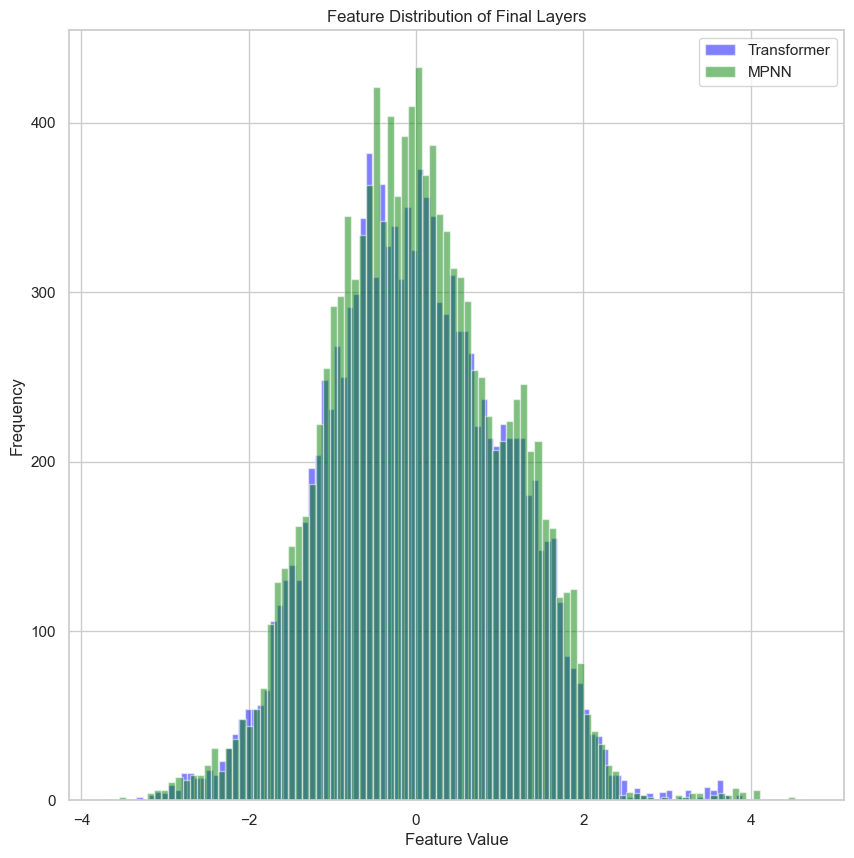

In [42]:
final_layer_rt = jax.numpy.asarray(transformer_node_features_all_layers[2]).ravel()
final_layer_mpnn = jax.numpy.asarray(mpnn_node_features_all_layers[2]).ravel()
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.hist(final_layer_rt, color='blue', alpha=0.5, label='Transformer', bins=100)
ax.hist(final_layer_mpnn, color='green', alpha=0.5, label='MPNN', bins=100)

ax.legend()

ax.set_title('Feature Distribution of Final Layers')
ax.set_xlabel('Feature Value')
ax.set_ylabel('Frequency')
ax.grid(True)
plt.show()


In [ ]:
final_layer_rt = jax.numpy.asarray(transformer_node_features_all_layers[2]).ravel()
final_layer_mpnn = jax.numpy.asarray(mpnn_node_features_all_layers[2]).ravel()
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.hist(final_layer_rt, color='blue', alpha=0.5, label='Transformer', bins=100)
ax.hist(final_layer_mpnn, color='green', alpha=0.5, label='MPNN', bins=100)

ax.legend()

ax.set_title('Feature Distribution of Final Layers')
ax.set_xlabel('Feature Value')
ax.set_ylabel('Frequency')
ax.grid(True)
plt.show()


In [87]:
node_features_out_A = np.load("dataset/train/3/out_node_features_2.npy")

In [91]:
node_features_out_B = np.load("dataset/train/4/out_node_features_2.npy")


In [92]:
np.array_equal(node_features_out_A, node_features_out_B)

False

In [93]:
train_dataloader = dataloader(DatasetPath.TRAIN_PATH)
(
    (
        input_node_features,
        input_edge_features,
        input_graph_features,
        input_adjacency_matrix,
        input_hidden_node_features,
    ),
    transformer_node_features_all_layers_A,
    transformer_edge_embedding_A,
) = next(train_dataloader)

In [98]:
(
    (
        input_node_features,
        input_edge_features,
        input_graph_features,
        input_adjacency_matrix,
        input_hidden_node_features,
    ),
    transformer_node_features_all_layers_B,
    transformer_edge_embedding_B,
) = next(train_dataloader)

In [100]:
(
    (
        input_node_features,
        input_edge_features,
        input_graph_features,
        input_adjacency_matrix,
        input_hidden_node_features,
    ),
    transformer_node_features_all_layers_C,
    transformer_edge_embedding_C,
) = next(train_dataloader)

In [101]:
last_layer_A = transformer_node_features_all_layers_A[-1]
last_layer_B = transformer_node_features_all_layers_B[-1]
last_layer_C = transformer_node_features_all_layers_C[-1]

In [104]:
np.array_equal(last_layer_B, last_layer_C)

False

In [107]:
last_layer_A[0]


array([[ 1.7343624 ,  0.19012073,  0.29613346, ...,  0.699832  ,
         0.13240938, -1.8582584 ],
       [ 1.867667  , -0.19093959,  0.6584974 , ..., -0.41615173,
         0.33591473, -1.6156723 ],
       [ 2.1921008 ,  0.33910093,  1.1122538 , ..., -0.19687067,
         0.4629984 , -1.1446904 ],
       ...,
       [ 2.0276155 ,  0.0179211 ,  1.2217915 , ..., -0.63743204,
         0.45384264, -1.1466236 ],
       [ 1.7214953 , -0.38348767,  1.0700846 , ..., -1.1446707 ,
         0.38456535, -1.1987085 ],
       [ 2.1597834 ,  0.06559233,  1.2401975 , ..., -0.3232518 ,
         0.5208501 , -1.2864748 ]], dtype=float32)

In [108]:
last_layer_B[0]

array([[ 1.4909484 ,  0.2837955 , -0.2064019 , ...,  0.5694642 ,
         0.1688293 , -2.052472  ],
       [ 2.077046  ,  0.1991594 ,  0.81570417, ..., -0.6480917 ,
         0.4582893 , -1.403863  ],
       [ 2.0456533 ,  0.2528514 ,  0.9809095 , ..., -0.7330611 ,
         0.36298877, -1.3025411 ],
       ...,
       [ 1.4884087 ,  0.01744392,  0.2310963 , ..., -0.74340934,
        -0.1519777 , -1.0007207 ],
       [ 1.8456417 ,  0.42854333,  0.84952664, ..., -0.75003135,
         0.80538255, -1.2186248 ],
       [ 1.7269664 , -0.25812277,  1.0487407 , ..., -1.1313595 ,
         0.4599795 , -1.1592445 ]], dtype=float32)